## **Описание задания**


Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.


## **Набор данных**

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

* user_id - уникальный id пользователя
* order_completed_at - дата заказа
* cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

* id - идентификатор строки - состоит из user_id и category_id, разделенных
точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
* target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя


## **Этапы решения:**

**1. Подготовка данных:**

Сначала загружаются тренировочные и тестовые данные. Затем удаляются ненужные столбцы и создаются новые столбцы для хранения информации о количестве заказов, рейтинге категорий и количестве уникальных категорий для каждого пользователя.

**2. Кластеризация данных:**

Используется метод KMeans для группировки пользователей по схожести их покупательских привычек. Это позволяет определить группы пользователей с похожими предпочтениями.

**3. Подготовка тестового набора данных:**

Обогащение тестового набора sample_submission.csv столбцами с признаками. Чтобы в дальнейшем применить обученую модель к тесстовым данным.

**4. Обучение модели:**

С помощью модели случайного леса проводится обучение на основе исторических данных о заказах.

**5. Прогнозирование следующего заказа:**

На основе кластеризации и предыдущих заказов каждого пользователя делается прогноз о том, какие категории товаров будут включены в следующий заказ.

**6. Тестирование модели:**

Модель применяется к тестовым данным для проверки ее эффективности.

**7. Сохранение результатов:**

Результаты сохраняются в формате CSV для дальнейшего использования.
Сложные участки кода включают использование метода KMeans для кластеризации данных и применение модели случайного леса для прогнозирования следующего заказа. Эти участки кода требуют настройки параметров и оптимизации для достижения наилучших результатов.

## 1_Подготовка данных:

In [1]:
import pandas as pd
import numpy as np

### Загрузка данных

In [2]:
# Загрузка тестовых данных
sub_df = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/sample_submission.csv')
sub_df

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [3]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

X_data = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/train.csv')


In [5]:
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


In [6]:
# Сортируем DataFrame по столбцу 'order_completed_at' по возрастанию
X_data = X_data.sort_values(by='order_completed_at')

In [7]:
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
15,2,2015-03-22 09:25:46,425
14,2,2015-03-22 09:25:46,57
13,2,2015-03-22 09:25:46,89
11,2,2015-03-22 09:25:46,84
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


In [8]:
# Фильтруем данные, чтобы оставить только последние 10000 заказов
new_data = X_data.tail(10000)

In [9]:
new_data

,user_id,order_completed_at,cart
3113062,13767,2020-09-03 07:18:34,384
3113061,13767,2020-09-03 07:18:34,15
3113060,13767,2020-09-03 07:18:34,9
3113063,13767,2020-09-03 07:18:34,61
3113081,10967,2020-09-03 07:18:52,385
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


In [10]:
# Фильтруем данные, чтобы оставить все, кроме последних 10000 заказов
X_data = X_data.head(-10000)

In [11]:
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
15,2,2015-03-22 09:25:46,425
14,2,2015-03-22 09:25:46,57
13,2,2015-03-22 09:25:46,89
11,2,2015-03-22 09:25:46,84
...,...,...,...
3113055,14004,2020-09-03 07:18:17,5
3113067,13767,2020-09-03 07:18:34,14
3113066,13767,2020-09-03 07:18:34,398
3113064,13767,2020-09-03 07:18:34,420


In [12]:
pivot_table = X_data.pivot_table(index='user_id', columns='cart', aggfunc='size').fillna(0)


In [13]:
pivot_table

cart,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cos_sim = cosine_similarity(pivot_table)
cos_sim = pd.DataFrame(cos_sim, index=pivot_table.index, columns=pivot_table.index)


In [15]:
cos_sim

user_id,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
user_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.240469,0.491615,0.421983,0.349928,0.364306,0.379566,0.465593,0.404969,0.201796,...,0.081230,0.317735,0.460375,0.238302,0.317500,0.338667,0.400427,0.323290,0.342148,0.0
1,0.240469,1.000000,0.129383,0.069561,0.102911,0.185164,0.203389,0.077393,0.204372,0.126583,...,0.018349,0.066254,0.172133,0.260875,0.258199,0.086066,0.146119,0.279947,0.061832,0.0
2,0.491615,0.129383,1.000000,0.533248,0.461099,0.444702,0.517206,0.603112,0.512507,0.404688,...,0.232365,0.405032,0.474477,0.254953,0.444724,0.288131,0.428407,0.473030,0.357749,0.0
3,0.421983,0.069561,0.533248,1.000000,0.424844,0.391772,0.368261,0.571484,0.466091,0.207551,...,0.210606,0.328368,0.426563,0.168505,0.254441,0.269408,0.283144,0.317500,0.306452,0.0
4,0.349928,0.102911,0.461099,0.424844,1.000000,0.441173,0.487807,0.460295,0.537885,0.324960,...,0.155173,0.370185,0.357414,0.232616,0.320590,0.346583,0.290003,0.397016,0.494873,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.338667,0.086066,0.288131,0.269408,0.346583,0.418330,0.208514,0.368914,0.384457,0.227617,...,0.071067,0.384900,0.250000,0.048113,0.388889,1.000000,0.323381,0.282843,0.419079,0.0
19996,0.400427,0.146119,0.428407,0.283144,0.290003,0.246403,0.370863,0.352307,0.370236,0.165616,...,0.103418,0.280056,0.333486,0.140028,0.404226,0.323381,1.000000,0.274398,0.261364,0.0
19997,0.323290,0.279947,0.473030,0.317500,0.397016,0.270449,0.275225,0.283687,0.374196,0.220997,...,0.090453,0.326599,0.353553,0.142887,0.306413,0.282843,0.274398,1.000000,0.304800,0.0


In [16]:
import numpy as np
np.fill_diagonal(cos_sim.values, -np.inf)
most_similar_users = cos_sim.idxmax(axis=1)



In [17]:
most_similar_users


user_id
0         1552
1         8118
2          709
3         8455
4        15054
         ...  
19995    14345
19996     3759
19997     9986
19998    17294
19999    14743
Length: 20000, dtype: int64

In [18]:
# Подсчитываем общее количество категорий товаров
num_categories = pivot_table.shape[1]

In [19]:
num_categories

881

In [20]:
purchase_proba = pivot_table.copy()  # Создаем копию сводной таблицы

In [21]:
purchase_proba

cart,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Рассчитываем вероятность покупки, деля каждую строку сводной таблицы на количество категорий
purchase_proba = (purchase_proba + 1).div(num_categories, axis=0)


In [23]:
purchase_proba

cart,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.001135,0.001135,0.001135,0.001135,0.001135,0.002270,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
1,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
2,0.002270,0.001135,0.001135,0.001135,0.001135,0.003405,0.001135,0.001135,0.001135,0.002270,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
3,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
4,0.001135,0.001135,0.001135,0.001135,0.001135,0.003405,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002270,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
19996,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135
19997,0.002270,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,...,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135


In [24]:
# Рассчитываем среднее количество покупок каждой категории среди всех пользователей
category_rating = pivot_table.mean()

In [25]:
category_rating

cart
0      0.91655
1      0.01775
2      0.00150
3      0.00005
4      0.01095
        ...   
876    0.00010
877    0.00025
878    0.00030
879    0.00020
880    0.00055
Length: 881, dtype: float64

In [26]:
kmeans = KMeans(n_clusters=3).fit(pivot_table)
clusters = pd.Series(kmeans.labels_, index=pivot_table.index)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
df1 = pd.DataFrame(most_similar_users, columns=['most_similar_user'])
df2 = pd.DataFrame(purchase_proba.stack(), columns=['purchase_proba'])
df3 = pd.DataFrame(clusters, columns=['cluster'])
df4 = pd.DataFrame(category_rating, columns=['category_rating'])



In [28]:
result = df1.merge(df2, left_index=True, right_index=True).merge(df3, left_index=True, right_index=True).merge(df4, left_index=True, right_index=True)

In [29]:
result

most_similar_user  purchase_proba  cluster  category_rating
user_id cart                                                             
0       0                  1552        0.001135        2          0.91655
        1                  1552        0.001135        2          0.01775
        2                  1552        0.001135        2          0.00150
        3                  1552        0.001135        2          0.00005
        4                  1552        0.001135        2          0.01095
...                         ...             ...      ...              ...
19999   876               14743        0.001135        2          0.00010
        877               14743        0.001135        2          0.00025
        878               14743        0.001135        2          0.00030
        879               14743        0.001135        2          0.00020
        880               14743        0.001135        2          0.00055

[17620000 rows x 4 columns]

In [30]:
# Преобразование индексов 'user_id' и 'cart' в столбцы
result.reset_index(inplace=True)

In [31]:
# Вывод измененного DataFrame
result

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating
0,0,0,1552,0.001135,2,0.91655
1,0,1,1552,0.001135,2,0.01775
2,0,2,1552,0.001135,2,0.00150
3,0,3,1552,0.001135,2,0.00005
4,0,4,1552,0.001135,2,0.01095
...,...,...,...,...,...,...
17619995,19999,876,14743,0.001135,2,0.00010
17619996,19999,877,14743,0.001135,2,0.00025
17619997,19999,878,14743,0.001135,2,0.00030
17619998,19999,879,14743,0.001135,2,0.00020


In [32]:
# Выбираем несколько наиболее похожих пользователей для каждого пользователя
num_similar_users = 10  # количество наиболее похожих пользователей
top_similar_users = cos_sim.apply(lambda x: x.nlargest(num_similar_users).index.tolist(), axis=1)

In [33]:
top_similar_users

user_id
0        [1552, 2758, 17882, 3666, 474, 1904, 11032, 12...
1        [8118, 3198, 9155, 5484, 10082, 10656, 195, 13...
2        [709, 6380, 10855, 15285, 10743, 12408, 8430, ...
3        [8455, 6525, 3292, 3483, 3190, 4224, 7151, 181...
4        [15054, 12466, 55, 6704, 114, 1142, 8351, 4748...
                               ...                        
19995    [14345, 14731, 12673, 8489, 17242, 5992, 11814...
19996    [3759, 17499, 1926, 3960, 45, 5787, 1749, 1984...
19997    [9986, 7246, 9120, 19657, 15422, 349, 10617, 1...
19998    [17294, 5976, 9014, 17270, 12101, 12791, 1558,...
19999    [14743, 11201, 18783, 15964, 7154, 1484, 10432...
Length: 20000, dtype: object

In [34]:
most_similar_purchase_proba = (pivot_table.loc[top_similar_users.explode()].mean() + 1).div(num_categories)


In [35]:
most_similar_purchase_proba

cart
0      0.003749
1      0.001190
2      0.001138
3      0.001136
4      0.001173
         ...   
876    0.001135
877    0.001135
878    0.001135
879    0.001135
880    0.001137
Length: 881, dtype: float64

In [36]:
# Создайте словарь, где ключами будут значения 'cart', а значениями - соответствующие вероятности покупки от наиболее похожих пользователей
purchase_proba_dict = most_similar_purchase_proba.to_dict()


In [37]:
# Создание столбца 'most_similar_purchase_proba' с помощью метода map и словаря purchase_proba_dict
result['most_similar_purchase_proba'] = result['cart'].map(purchase_proba_dict)


In [38]:
result

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba
0,0,0,1552,0.001135,2,0.91655,0.003749
1,0,1,1552,0.001135,2,0.01775,0.001190
2,0,2,1552,0.001135,2,0.00150,0.001138
3,0,3,1552,0.001135,2,0.00005,0.001136
4,0,4,1552,0.001135,2,0.01095,0.001173
...,...,...,...,...,...,...,...
17619995,19999,876,14743,0.001135,2,0.00010,0.001135
17619996,19999,877,14743,0.001135,2,0.00025,0.001135
17619997,19999,878,14743,0.001135,2,0.00030,0.001135
17619998,19999,879,14743,0.001135,2,0.00020,0.001135


In [39]:
cluster_counts = result['cluster'].value_counts()
print(cluster_counts)


cluster
2    14553239
1     2679121
0      387640
Name: count, dtype: int64


In [40]:
result

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba
0,0,0,1552,0.001135,2,0.91655,0.003749
1,0,1,1552,0.001135,2,0.01775,0.001190
2,0,2,1552,0.001135,2,0.00150,0.001138
3,0,3,1552,0.001135,2,0.00005,0.001136
4,0,4,1552,0.001135,2,0.01095,0.001173
...,...,...,...,...,...,...,...
17619995,19999,876,14743,0.001135,2,0.00010,0.001135
17619996,19999,877,14743,0.001135,2,0.00025,0.001135
17619997,19999,878,14743,0.001135,2,0.00030,0.001135
17619998,19999,879,14743,0.001135,2,0.00020,0.001135


In [41]:
# Заданный пороговый уровень для purchase_proba
threshold = 0.0011350737797956867

# Добавление столбца target на основе условия purchase_proba > threshold
result['target'] = (result['purchase_proba'] > threshold).astype(int)


In [42]:
result.columns

Index(['user_id', 'cart', 'most_similar_user', 'purchase_proba', 'cluster',
       'category_rating', 'most_similar_purchase_proba', 'target'],
      dtype='object')

In [43]:
new_data

,user_id,order_completed_at,cart
3113062,13767,2020-09-03 07:18:34,384
3113061,13767,2020-09-03 07:18:34,15
3113060,13767,2020-09-03 07:18:34,9
3113063,13767,2020-09-03 07:18:34,61
3113081,10967,2020-09-03 07:18:52,385
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


In [44]:
# Объединяем new_data и result по столбцам cart и user_id с помощью left join
merged_data = pd.merge(new_data, result, on=['cart', 'user_id'], how='left')

In [45]:
merged_data

,user_id,order_completed_at,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
0,13767,2020-09-03 07:18:34,384,7212,0.007946,1,1.63900,0.005741,1
1,13767,2020-09-03 07:18:34,15,7212,0.010216,1,1.25500,0.004876,1
2,13767,2020-09-03 07:18:34,9,7212,0.023837,1,1.79220,0.006354,1
3,13767,2020-09-03 07:18:34,61,7212,0.013621,1,4.55995,0.015503,1
4,10967,2020-09-03 07:18:52,385,2337,0.005675,2,0.55110,0.002531,1
...,...,...,...,...,...,...,...,...,...
9995,12702,2020-09-03 23:45:45,54,7176,0.001135,2,1.42535,0.004964,0
9996,12702,2020-09-03 23:45:45,382,7176,0.003405,2,2.33615,0.007779,1
9997,12702,2020-09-03 23:45:45,24,7176,0.002270,2,0.79785,0.003445,1
9998,12702,2020-09-03 23:45:45,376,7176,0.003405,2,1.22370,0.004677,1


In [46]:
# Создаем новый DataFrame 'new' с выбранными столбцами из 'merged_data'
new = merged_data[['user_id', 'cart', 'most_similar_user', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba', 'target']]

In [47]:
new

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
0,13767,384,7212,0.007946,1,1.63900,0.005741,1
1,13767,15,7212,0.010216,1,1.25500,0.004876,1
2,13767,9,7212,0.023837,1,1.79220,0.006354,1
3,13767,61,7212,0.013621,1,4.55995,0.015503,1
4,10967,385,2337,0.005675,2,0.55110,0.002531,1
...,...,...,...,...,...,...,...,...
9995,12702,54,7176,0.001135,2,1.42535,0.004964,0
9996,12702,382,7176,0.003405,2,2.33615,0.007779,1
9997,12702,24,7176,0.002270,2,0.79785,0.003445,1
9998,12702,376,7176,0.003405,2,1.22370,0.004677,1


In [48]:
# Заполняем столбец 'target' полностью значением '1' с использованием .loc
new.loc[:, 'target'] = 1

In [49]:
new

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
0,13767,384,7212,0.007946,1,1.63900,0.005741,1
1,13767,15,7212,0.010216,1,1.25500,0.004876,1
2,13767,9,7212,0.023837,1,1.79220,0.006354,1
3,13767,61,7212,0.013621,1,4.55995,0.015503,1
4,10967,385,2337,0.005675,2,0.55110,0.002531,1
...,...,...,...,...,...,...,...,...
9995,12702,54,7176,0.001135,2,1.42535,0.004964,1
9996,12702,382,7176,0.003405,2,2.33615,0.007779,1
9997,12702,24,7176,0.002270,2,0.79785,0.003445,1
9998,12702,376,7176,0.003405,2,1.22370,0.004677,1


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# Уменьшение объема данных до 1000 строк путем случайной выборки
sampled_data = result.sample(n=10000, random_state=1)

In [91]:
sampled_data

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
15936963,18089,554,897,0.001135,2,0.00010,0.001135,0
1622414,1841,493,7548,0.001135,2,0.00155,0.001138,0
12318736,13982,594,1805,0.001135,2,0.00010,0.001135,0
6724485,7632,693,12609,0.001135,1,0.00010,0.001135,0
13524927,15351,696,5546,0.001135,2,0.00015,0.001135,0
...,...,...,...,...,...,...,...,...
5474279,6213,626,1157,0.001135,2,0.00060,0.001137,0
5296350,6011,659,11127,0.001135,2,0.00110,0.001141,0
8894405,10095,710,3013,0.001135,2,0.00555,0.001150,0
3391264,3849,295,8533,0.001135,2,0.00315,0.001143,0


In [52]:
# Создаем справочник user_id из sampled_data
user_id_reference = pd.DataFrame(sampled_data['user_id'].unique(), columns=['user_id'])



In [53]:
user_id_reference

,user_id
0,18089
1,1841
2,13982
3,7632
4,15351
...,...
7875,3491
7876,15674
7877,6213
7878,3849


In [54]:
# Удаляем из new тех user_id, которых нет в справочнике
new = new[new['user_id'].isin(user_id_reference['user_id'])]

In [78]:
new

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
4,10967,385,2337,0.005675,2,0.55110,0.002531,1
5,10967,41,2337,0.006810,2,2.18995,0.007447,1
6,10967,14,2337,0.005675,2,4.68115,0.015380,1
7,10967,402,2337,0.005675,2,2.48760,0.008512,1
8,10967,215,2337,0.001135,2,0.01455,0.001173,1
...,...,...,...,...,...,...,...,...
9995,12702,54,7176,0.001135,2,1.42535,0.004964,1
9996,12702,382,7176,0.003405,2,2.33615,0.007779,1
9997,12702,24,7176,0.002270,2,0.79785,0.003445,1
9998,12702,376,7176,0.003405,2,1.22370,0.004677,1


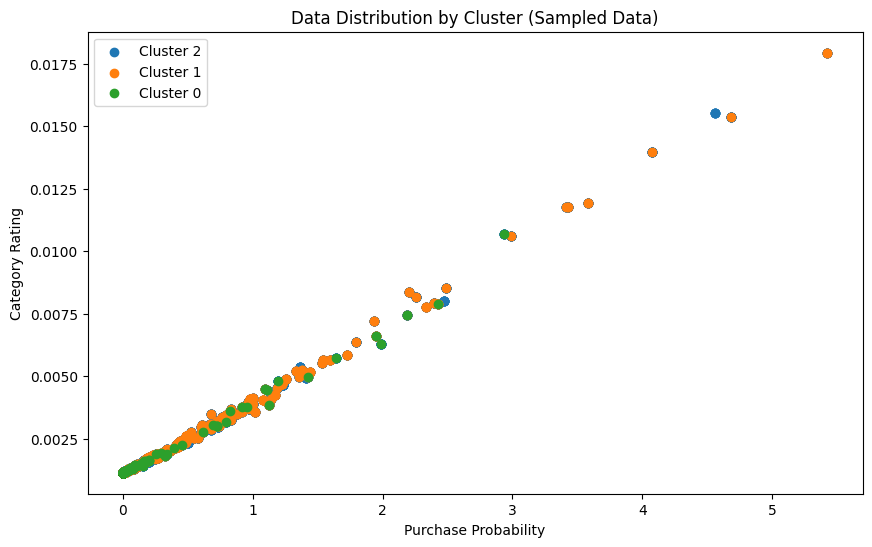

In [56]:


import matplotlib.pyplot as plt

# Визуализация данных по кластерам на scatter plot с уменьшенными данными
plt.figure(figsize=(10, 6))
for cluster in sampled_data['cluster'].unique():
    cluster_data = sampled_data[sampled_data['cluster'] == cluster]
    plt.scatter(cluster_data['category_rating'], cluster_data['most_similar_purchase_proba'], label=f'Cluster {cluster}')

plt.xlabel('Purchase Probability')
plt.ylabel('Category Rating')
plt.title('Data Distribution by Cluster (Sampled Data)')
plt.legend()
plt.show()



In [83]:
sampled_data.columns

Index(['user_id', 'cart', 'most_similar_user', 'purchase_proba', 'cluster',
       'category_rating', 'most_similar_purchase_proba', 'target'],
      dtype='object')

In [88]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

# Данные
X_train = sampled_data[['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']]
y_train = sampled_data['target']
X_test = new[['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']]
y_test = new['target']

# Создаем объект StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Модель 1: Логистическая регрессия с кросс-валидацией (и регуляризация)
logreg_cv = LogisticRegressionCV(cv=kf, max_iter=1000).fit(X_train, y_train)

logreg_scores = cross_val_score(logreg_cv, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (Logistic Regression): {logreg_scores}')
print(f'Средняя оценка (Logistic Regression): {np.mean(logreg_scores)}')

# Точность на тестовых данных
logreg_cv_test_accuracy = logreg_cv.score(X_test, y_test)
print(f'Tочность на тестовых данных (Logistic Regression): {logreg_cv_test_accuracy}')
print()

# Модель 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=kf)
rf.fit(X_train, y_train)

rf_train_accuracy = rf.score(X_train, y_train)
rf_test_accuracy = rf.score(X_test, y_test)

print(f'Кросс-валидационные оценки (Random Forest): {rf_scores}')
print(f'Средняя оценка (Random Forest): {np.mean(rf_scores)}')
print(f'Tочность на тренировочных данных (Random Forest): {rf_train_accuracy}')
print(f'Tочность на тестовых данных (Random Forest): {rf_test_accuracy}')
print()
# Модель 3: SVM
svm = SVC(C=1.0, kernel='rbf', random_state=42)
svm_scores = cross_val_score(svm, X_train, y_train, cv=kf)
svm.fit(X_train, y_train)

svm_train_accuracy = svm.score(X_train, y_train)
svm_test_accuracy = svm.score(X_test, y_test)

print(f'Кросс-валидационные оценки (SVM): {svm_scores}')
print(f'Средняя оценка (SVM): {np.mean(svm_scores)}')
print(f'Tочность на тренировочных данных (SVM): {svm_train_accuracy}')
print(f'Tочность на тестовых данных (SVM): {svm_test_accuracy}')


Кросс-валидационные оценки (Logistic Regression): [0.944  0.944  0.9435 0.9445 0.947 ]
Средняя оценка (Logistic Regression): 0.9446
Tочность на тестовых данных (Logistic Regression): 0.46212306937974995

Кросс-валидационные оценки (Random Forest): [1. 1. 1. 1. 1.]
Средняя оценка (Random Forest): 1.0
Tочность на тренировочных данных (Random Forest): 1.0
Tочность на тестовых данных (Random Forest): 0.7531257661191468

Кросс-валидационные оценки (SVM): [0.9355 0.9355 0.935  0.935  0.935 ]
Средняя оценка (SVM): 0.9352
Tочность на тренировочных данных (SVM): 0.9352
Tочность на тестовых данных (SVM): 0.0


In [89]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Создаем объект StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Стандартный скалер и полиномиальные признаки
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

# Модель 1: Логистическая регрессия с кросс-валидацией (и регуляризация)
logreg_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('logreg', LogisticRegressionCV(cv=kf, max_iter=1000))
])
logreg_pipe.fit(X_train, y_train)

logreg_scores = cross_val_score(logreg_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (Logistic Regression): {logreg_scores}')
print(f'Средняя оценка (Logistic Regression): {np.mean(logreg_scores)}')

# Точность на тестовых данных
logreg_test_accuracy = logreg_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (Logistic Regression): {logreg_test_accuracy}')
print()

# Модель 2: Random Forest
rf_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipe.fit(X_train, y_train)

rf_scores = cross_val_score(rf_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (Random Forest): {rf_scores}')
print(f'Средняя оценка (Random Forest): {np.mean(rf_scores)}')

# Точность на тестовых данных
rf_test_accuracy = rf_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (Random Forest): {rf_test_accuracy}')
print()

# Модель 3: SVM
svm_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('svm', SVC(C=1.0, kernel='rbf', random_state=42))
])
svm_pipe.fit(X_train, y_train)

svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (SVM): {svm_scores}')
print(f'Средняя оценка (SVM): {np.mean(svm_scores)}')

# Точность на тестовых данных
svm_test_accuracy = svm_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (SVM): {svm_test_accuracy}')


Кросс-валидационные оценки (Logistic Regression): [1. 1. 1. 1. 1.]
Средняя оценка (Logistic Regression): 1.0
Tочность на тестовых данных (Logistic Regression): 0.7531257661191468

Кросс-валидационные оценки (Random Forest): [1. 1. 1. 1. 1.]
Средняя оценка (Random Forest): 1.0
Tочность на тестовых данных (Random Forest): 0.7531257661191468

Кросс-валидационные оценки (SVM): [0.9975 0.9935 0.994  0.9885 0.995 ]
Средняя оценка (SVM): 0.9937000000000001
Tочность на тестовых данных (SVM): 0.7420936504045109


### Готовим дополнительные столбцы с признаками

* Рейтинг категорий среди всех пользователей
* Рейтинг категорий для каждого пользователя
* Столбец со значениями 1 (был заказ) 0 (небыло заказа)





### Делим пользователей на классы, чтобы передать класс как признак для обучения модели.

### Вычисляем Методом локтя количество кластеров

Принимаем оптимальное значение кластера как `4`

### Добавляем столбец `cluster` с метками кластеров

### Готовим тестовый набор данных `sample_submission.csv`

### Обогащаем тестовый набор данных признаками